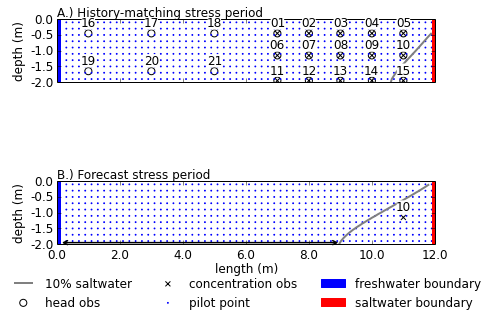

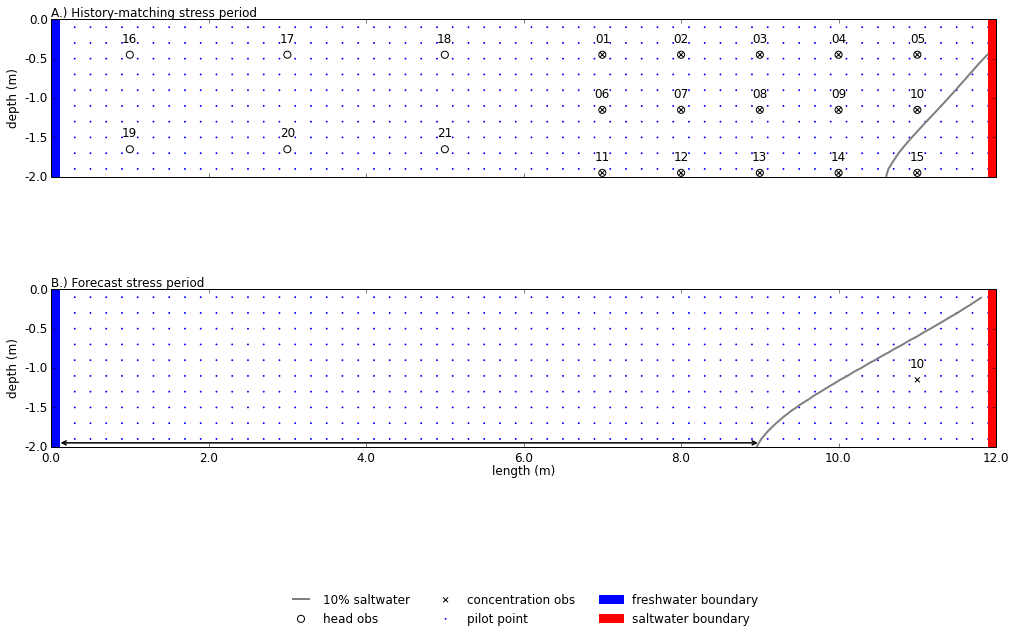

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import plot_domain
plot_domain.henry_domain()
plt.show()

##Model background
Here is an example based on the Henry saltwater intrusion problem.  The synthetic model is a 2-dimensional SEAWAT model (X-Z domain) with 1 row, 120 columns and 20 layers.  The left boundary is a specified flux of freshwater, the right boundary is a specified head and concentration saltwater boundary.  The model has two stress periods: an initial steady state (calibration) period, then a transient period with less flux (forecast).  

The inverse problem has 603 parameters: 600 hydraulic conductivity pilot points, 1 global hydraulic conductivity, 1 specified flux multiplier for history matching and 1 specified flux multiplier for forecast conditions.  The inverse problem has 36 obseravtions (21 heads and 15 concentrations) measured at the end of the steady-state calibration period.  The forecasts of interest of the distance from the left model edge to the 10% seawater concentration in the basal model layer and the concentration at location 10.  Both of there forecasts are "measured" at the end of the forecast stress period.  The forecasts are both in the Jacobian matrix as zero-weight observations named `pd_ten` and `C_obs10_2`.I previously calculated the jacobian matrix, which is in the `henry/` folder, along with the PEST control file.

Unlike the Schur's complement example notebook, here we will examine the consequences of not adjusting the specified flux multiplier parameters (```mult1``` and ```mult2```) during inversion, since these types of model inputs are not typically considered for adjustment.


##Using `pyemu`

In [2]:
import pyemu

First create a linear_analysis object.  We will use `err_var`  derived type, which replicates the behavior of the `PREDVAR` suite of PEST as well as `ident_par` utility.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.  Remember you can pass a filename to the `verbose` argument to write log file.

Since most groundwater model history-matching analyses focus on adjusting hetergeneous hydraulic properties and not boundary condition elements, let's identify the ```mult1``` and ```mult2``` parameters as `omitted` in the error variance analysis.  We can conceptually think of this action as excluding the ```mult1``` and ```mult2``` parameters from the history-matching process. Later we will explicitly calculate the penalty for not adjusting this parameter.

In [3]:
forecasts = ["pd_ten","c_obs10_2"]
la = pyemu.errvar(jco=os.path.join("henry", "pest.jcb"),
                  forecasts=forecasts,
                  omitted_parameters=["mult1","mult2"])
print(la.jco.shape) #without the omitted parameter or the prior info

(73, 601)


#Parameter identifiability
The `errvar` dervied type exposes a method to get a `pandas` dataframe of parameter identifiability information.  Recall that parameter identifiability is expressed as $d_i = \Sigma(\mathbf{V}_{1i})^2$, where $d_i$ is the parameter identifiability, which ranges from 0 (not identified by the data) to 1 (full identified by the data), and $\mathbf{V}_1$ are the right singular vectors corresonding to non-(numerically) zero singular values.  First let's look at the singular spectrum of $\mathbf{Q}^{\frac{1}{2}}\mathbf{J}$, where $\mathbf{Q}$ is the cofactor matrix and $\mathbf{J}$ is the jacobian:

In [4]:
s = la.qhalfx.s

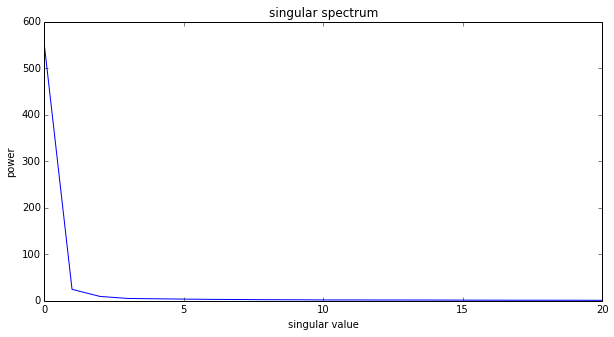

In [5]:
import pylab as plt
figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(s.x)
ax.set_title("singular spectrum")
ax.set_ylabel("power")
ax.set_xlabel("singular value")
ax.set_xlim(0,20)
plt.show()

We see that the singluar spectrum decays rapidly (not uncommon) and that we can really only support about 3 right singular vectors even though we have 600+ parameters in the inverse problem.  

Let's get the identifiability dataframe at 15 singular vectors:

In [6]:
ident_df = la.get_identifiability_dataframe(3) # the method is passed the number of singular vectors to include in V_1
ident_df.sort().iloc[0:10]

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,ident
global_k,9.966007e-01,1.084435e-03,2.834900e-04,9.979687e-01
kr01c01,3.816852e-13,2.180892e-10,9.040267e-09,9.258738e-09
kr01c02,1.350066e-10,3.028964e-08,2.157027e-07,2.461273e-07
kr01c03,5.034623e-10,9.942224e-08,5.901479e-07,6.900736e-07
kr01c04,3.504914e-09,7.431553e-07,5.734484e-06,6.481144e-06
kr01c05,4.865283e-08,1.076199e-05,9.525053e-05,1.060612e-04
kr01c06,1.994828e-07,4.468856e-05,4.137545e-04,4.586425e-04
kr01c07,3.518241e-07,7.861029e-05,7.174784e-04,7.964405e-04
kr01c08,3.663874e-07,8.183073e-05,7.459506e-04,8.281478e-04
kr01c09,3.755248e-07,8.321196e-05,7.337729e-04,8.173604e-04


Plot the indentifiability:

We see that the `global_k` parameter has a much higher identifiability than any one of the 600 pilot points

#Forecast error variance 

Now let's explore the error variance of the forecasts we are interested in.  We will use an extended version of the forecast error variance equation:   

$\sigma_{s - \hat{s}}^2 = \underbrace{\textbf{y}_i^T({\bf{I}} - {\textbf{R}})\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_i}({\textbf{I}} - {\textbf{R}})^T\textbf{y}_i}_{1} + \underbrace{{\textbf{y}}_i^T{\bf{G}}\boldsymbol{\Sigma}_{\mathbf{\epsilon}}{\textbf{G}}^T{\textbf{y}}_i}_{2} + \underbrace{{\bf{p}}\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_o}{\bf{p}}^T}_{3}$

Where term 1 is the null-space contribution, term 2 is the solution space contribution and term 3 is the model error term (the penalty for not adjusting uncertain parameters).  Remember the `mult1` and `mult2` parameters that we marked as omitted?  The consequences of that action can now be explicitly evaluated.  See Moore and Doherty (2005) and White and other (2014) for more explanation of these terms.  Note that if you don't have any `omitted_parameters`, the only terms 1 and 2 contribute to error variance

First we need to create a list (or numpy ndarray) of the singular values we want to test.  Since we have $\lt40$ data, we only need to test up to $40$ singular values because that is where the action is:

In [7]:
sing_vals = np.arange(40)

The `errvar` derived type exposes a convience method to get a multi-index pandas dataframe with each of the terms of the error variance equation:

In [8]:
errvar_df = la.get_errvar_dataframe(sing_vals)
errvar_df.iloc[0:10]

first              second               third          
  c_obs10_2    pd_ten c_obs10_2    pd_ten c_obs10_2    pd_ten
0  0.839807  3.767852  0.000000  0.000000  0.183547  0.898063
1  0.390040  1.143221  0.000251  0.001890  0.290467  1.512740
2  0.152808  0.916769  0.001810  0.003379  0.254220  1.418017
3  0.152567  0.888371  0.001821  0.004660  0.253266  1.447760
4  0.148153  0.867596  0.002512  0.007910  0.257929  1.477116
5  0.120518  0.867447  0.008497  0.007942  0.270438  1.474536
6  0.096935  0.860581  0.015565  0.010000  0.275265  1.467581
7  0.095462  0.860334  0.016207  0.010108  0.274894  1.467982
8  0.093688  0.858730  0.017148  0.010959  0.274024  1.465795
9  0.093310  0.845932  0.017417  0.020061  0.274652  1.456169

plot the error variance components for each forecast:

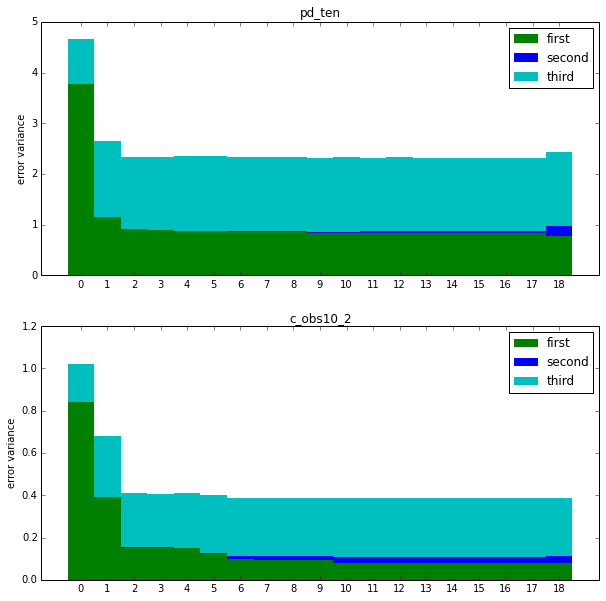

In [9]:
fig = plt.figure(figsize=(10, 10))
ax_1, ax_2= plt.subplot(211), plt.subplot(212)
axes = [ax_1,ax_2]

colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    ax = axes[ipred]
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", facecolor=colors["third"], label="third", bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    if ipred == 2:
        ax.set_xlabel("singular value")
    
    ax.set_ylabel("error variance")
    ax.legend(loc="upper right")
plt.show()


Here we see the trade off between getting a good fit to push down the null-space (1st) term and the penalty for overfitting (the rise of the solution space (2nd) term)).  The sum of the first two terms in the "appearent" error variance (e.g. the uncertainty that standard analyses would yield) without considering the contribution from the omitted parameters.  You can verify this be checking prior uncertainty from the Schur's complement notebook against the zero singular value result using only terms 1 and 2.

We also see the added penalty for not adjusting the `mult1` and `mult2` parameters (3rd term).  The ability to forecast the distance from the left edge of the model to the 10% saltwater concentration and the forecast the concentration at location 10 has been compromised by not adjusting `mult1` and `mult2` during calibration.  

Let's check the ```errvar``` results against the results from ```schur```. This is simple with ```pyemu```, we simply  cast the ```errvar``` type to a ```schur``` type:

In [10]:
schur = la.get(astype=pyemu.schur)
schur_prior = schur.prior_forecast
schur_post = schur.posterior_forecast
print("{0:10s} {1:>12s} {2:>12s} {3:>12s} {4:>12s}"
      .format("forecast","errvar prior","errvar min",
              "schur prior", "schur post"))
for ipred, pred in enumerate(forecasts):
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]  
    min_ev = np.min(first + second)
    prior_ev = first[0] + second[0]
    prior_sh = schur_prior[pred]
    post_sh = schur_post[pred]
    print("{0:12s} {1:12.6f} {2:12.6f} {3:12.6} {4:12.6f}"
          .format(pred,prior_ev,min_ev,prior_sh,post_sh))

forecast   errvar prior   errvar min  schur prior   schur post
pd_ten           3.767852     0.865610      3.76785     0.832397
c_obs10_2        0.839807     0.108566     0.839807     0.099357


We see that the prior from ```schur``` class matches the two-term ```errvar``` result at zero singular values.  We also see, as expected, the posterior from ```schur``` is slightly lower than the two-term ```errvar``` result.  This shows us that the "appearent" uncertainty in these predictions, as found through application of Bayes equation, is being under estimated because if the ill effects of the omitted ```mult1``` and ```mult2``` parameters.